# Ternary Multiplication in Triton

## Setup

In [1]:
%pip install --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly==3.0.0.post20240626041721

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


Check the installed triton version.

In [2]:
import triton

assert triton.__version__ == "3.0.0", f"Expected Triton to have a version of 3.0.0, but found {triton.__version__}"

Import other needed stuff.

In [3]:
import warnings

import torch
import triton.language as tl

## Helper Functions

In [4]:
def get_current_target():
    return triton.runtime.driver.active.get_current_target()

In [5]:
def is_cuda():
    current_target = get_current_target()
    if current_target.backend != "cuda":
        return False

    if current_target.arch < 70:  # CUDA compute capacity is below 7.0, which is minimum 'stable' supported by Triton
        warnings.warn(
            "Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!", stacklevel=1
        )

    return True

## 2D Ternary Multiplication Kernel

First, define the autotune config for the kernel.

In [6]:
def _get_autotune_config_2d():
    return [
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=5,
            num_warps=2,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=5,
            num_warps=2,
        )
    ]

In [7]:
def get_autotune_config_2d():
    if is_cuda():
        return _get_autotune_config_2d()
    else:
        raise ValueError("Not on CUDA... can't use!")

Now we define the Triton kernel. The rough pseudocode algorithm is as follows.
```python
# Do in parallel
for n in range(0, N, BLOCK_SIZE_N):
    acc = zeros((BLOCK_SIZE_N,), dtype=float32)
    for m in range(0, M, BLOCK_SIZE_M):
        x_block = x[m : m+BLOCK_SIZE_M]
        w_block = w[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N]
        
        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elems_to_sum = tl.where(w_block > 0, x_block, tl.where(w_block < 0, -x_block, tl.zeros_like(x_block)))
        acc += tl.sum(elems_to_sum)  # Sum along the M direction

    acc = acc / scale
    z[n : n+BLOCK_SIZE_N] = acc
```

In [8]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config_2d(),
    key=["M", "N"],
)
@triton.jit
def ternary_mul_2d_kernel(
    # Pointers to arrays
    x_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # `W` matrix dimensions
    M,
    N,
    # The stride variables represent how much to increase the pointer by when moving by 1 element in a particular
    # dimension. E.g. `stride_wm` is how much to increase `w_ptr` by to get the element one row down (the `W` matrix
    # has `M` rows).
    stride_xm,
    stride_wm,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the ternary multiplication
        z = xW
    `x` has shape `(1, M)`, `W` has shape `(M, N)`, and `z` has shape `(1, N)`.
    """

    # ----------------------------------------------------------
    # Create pointers for the first blocks of `x` and `W`.
    # We will advance this pointer as we move in the `M` direction and accumulate.
    # - `x_ptrs` is a block of `BLOCK_SIZE_M` pointers
    # - `w_ptrs` is a block of pointers with shape `(BLOCK_SIZE_M, BLOCK_SIZE_N)`
    pid_0 = tl.program_id(axis=0)

    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

    x_ptrs = x_ptr + offs_m
    w_ptrs = w_ptr + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the `z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
        # Load the next block of `x` and `W`, generate a mask by checking along `M`.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

        # Advance the ptrs to the next `M` block.
        x_ptrs += BLOCK_SIZE_M * stride_xm
        w_ptrs += BLOCK_SIZE_M * stride_wm

    z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

    # -----------------------------------------------------------
    # Write back the block of the output vector `z` with masks.
    offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_78746/3679571787.py:7: UserWarning: Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn(


Create a convenience wrapper function that handles the checks and kernel calling.

In [9]:
# ruff: noqa: E731, S101, N806
def ternary_mul_2d(x, w, scale):
    # Check constraints
    assert len(x) == w.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "x must be contiguous"
    assert x.is_cuda and w.is_cuda

    # Get dimensions
    M, N = w.shape

    # Allocate output
    z = torch.empty((N,), device=x.device, dtype=torch.float32)  # TODO: Change precision?

    # 1D launch kernel where each block gets its own program
    grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]),)

    # fmt: off
    ternary_mul_2d_kernel[grid](
        x, w, z,
        scale,
        M, N,
        x.stride(0),
        w.stride(0), w.stride(1)
    )
    # fmt: on

    return z

Test the kernel.

In [10]:
# X_LEN = 256  # x is the 1D vector
# W_LEN = 256  # W is the quantized weights matrix
# W_SIZE = (X_LEN, W_LEN)

In [11]:
# torch.manual_seed(8192)

In [12]:
# x = torch.rand(X_LEN, device="cuda", dtype=torch.float32)
# w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SIZE)]
# scale = torch.rand(1, dtype=torch.float32).item()

In [13]:
# torch_output = torch.matmul(x, w) / scale
# print(torch_output)

In [14]:
# triton_output = ternary_mul_2d(x, w, scale)
# print(triton_output)

In [15]:
# if torch.allclose(triton_output, torch_output, atol=1e-3):
#     print("✅ Triton and Torch match")
# else:
#     raise ValueError("❌ Triton and Torch differ")

Benchmark the Triton kernel against the standard Torch implementation of matmul.

In [16]:
# ref_lib = "cuBLAS"

# configs = [
#     triton.testing.Benchmark(
#         x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
#         x_vals=[128 * i for i in range(1, 31)],  # Different possible values for `x_name`
#         line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
#         # Possible values for `line_arg`
#         line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
#         line_names=[ref_lib, "Triton"],  # Line styles
#         styles=[("green", "-"), ("blue", "-")],
#         ylabel="GFLOPS",  # Label name for the y-axis
#         plot_name="ternary-mul-2d-performance",  # Name for the plot, used also as a file name for saving the plot.
#         args={},
#     )
# ]

# @triton.testing.perf_report(configs)
# def benchmark(M, N, provider):
#     print(f"Trial when M = {M} and N = {N} for {provider}")
#     x = torch.rand(M, device="cuda")
#     w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (M, N))]
#     scale = torch.rand(1, dtype=torch.float32).item()

#     quantiles = [0.5, 0.2, 0.8]
#     if provider == ref_lib.lower():
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
#     if provider == "triton":
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_2d(x, w, scale), quantiles=quantiles)
#     gflops = lambda ms: 2 * M * N * 1e-9 / (ms * 1e-3)
#     return gflops(ms), gflops(max_ms), gflops(min_ms)


# benchmark.run(show_plots=True, print_data=True)

## 3D Ternary Multiplication Kernel

The autotune config should be similar to the 2D case.

In [17]:
def get_autotune_config_3d():
    if is_cuda():
        return _get_autotune_config_2d()
    else:
        raise ValueError("Not on CUDA... can't use!")

The kernel's rough pseudocode algorithm is as follows.
```python
k = 0  # Output vector pointer

# Do in parallel
for i in range(0, num_elem_per_matrix, matrix_stride):
    # Do in parallel
    for j in range(0, num_elem_per_vector, vector_stride):
        matrix_elements = w_flat[i : i+matrix_stride].reshape(matrix_shape)
        vector_elements = x_flat[j : j+vector_stride]
        product = _2d_ternary_multiplication(vector_elements, matrix_elements, scale)
        output_flat[k : k+output_stride] = product
        k += output_stride

return output_flat.reshape(output_shape)
```

Note that `matrix_stride` and `vector_stride` may not be power-of-two values. Thus we will employ padding to ensure that achieve this, but using a mask to ensure that we don't get memory access errors.

In [72]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config_3d(),
    key=["M", "N"],
)
@triton.jit
def ternary_mul_3d_kernel(
    # Pointers to arrays
    x_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # `W` matrix dimensions
    K: tl.constexpr,
    M: tl.constexpr,
    N: tl.constexpr,
    # Strides
    stride_xk,
    stride_xm,
    stride_wk,
    stride_wm,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the ternary multiplication
        z = xW
    `x` has shape `(K, M)`, `W` has shape `(K, M, N)`, and `z` has shape `(K, K, N)`.
    """

    # -----------------------------------------------------------
    # Map `pid` to the correct `x` vector and `W` matrix blocks that we are computing
    pid_0 = tl.program_id(axis=0)
    pid_1 = tl.program_id(axis=1)

    pid_x = pid_1 % K
    pid_w = pid_1 // K

    # ----------------------------------------------------------
    # Create pointers for the `x` vector and `W` matrix
    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

    offs_x = pid_x * stride_xk + offs_m
    offs_w = pid_w * stride_wk + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

    x_ptrs = x_ptr + offs_x
    w_ptrs = w_ptr + offs_w

    # -----------------------------------------------------------
    # Iterate to compute a block of the `z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

    for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
        # Load the next block of `x` and `W`, generate a mask by checking along `M`.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

        # Since `w` is ternary, we only really care about the sign of the element in the array, and so  we just need to
        # perform two conditional checks
        elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

        # Advance the ptrs to the next `M` block.
        x_ptrs += BLOCK_SIZE_M * stride_xm
        w_ptrs += BLOCK_SIZE_M * stride_wm

    z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

    # -----------------------------------------------------------
    # Write back the block of the output vector `z` with masks
    offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + pid_1 * N + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_78746/3679571787.py:7: UserWarning: Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn(


Create a convenience wrapper function that handles the checks and kernel calling.

In [73]:
# ruff: noqa: E731, S101, N806
def ternary_mul_3d(x, w, scale):
    # Check constraints
    assert w.ndim == 3, "Weight matrix does not have suitable dimensionality"
    assert x.shape[-1] == w.shape[-2], "Incompatible dimensions"
    assert x.shape[0] == w.shape[0], "Incompatible batch sizes"
    assert x.is_contiguous(), "x must be contiguous"
    assert x.is_cuda and w.is_cuda

    # Get dimensions
    K, M, N = w.shape

    # Determine output size and shape
    z_shape = [K, K, N]
    num_processes = K * K
    z = torch.zeros(z_shape, device=x.device)

    # 2D launch kernel
    grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]), num_processes)

    # fmt: off
    ternary_mul_3d_kernel[grid](
        x, w, z,
        scale,
        K, M, N,
        x.stride(0), x.stride(1), w.stride(0), w.stride(1), w.stride(2)
    )
    # fmt: on

    return z

In [74]:
X_SHAPE = (8, 1)     # x is the vector
W_SHAPE = (8, 1, 1)  # W is the quantized weights matrix

In [75]:
torch.manual_seed(8192)

In [76]:
x = torch.rand(X_SHAPE, device="cuda", dtype=torch.float32)
w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SHAPE)]
scale = torch.rand(1, dtype=torch.float32).item()

In [77]:
torch_output = torch.matmul(x, w) / scale
print(torch_output)

tensor([[[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[-0.2817],
         [-1.0974],
         [-0.9181],
         [-0.3700],
         [-0.8689],
         [-0.2735],
         [-0.3603],
         [-0.3220]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[-0.2817],
         [-1.0974],
         [-0.9181],
         [-0.3700],
         [-0.8689],
         [-0.2735],
         [-0.3603],
         [-0.3220]],

        [[-0.2817],
         [-1.0974],
         [-0.9181],
         [-0.3700],
         [-0.8689],
         [-0.2735],
         [-0.3603],
         [-0.3220]],

        [[ 0.0000],
        

In [78]:
triton_output = ternary_mul_3d(x, w, scale)
print(triton_output)

tensor([[[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[-0.2817],
         [-1.0974],
         [-0.9181],
         [-0.3700],
         [-0.8689],
         [-0.2735],
         [-0.3603],
         [-0.3220]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[-0.2817],
         [-1.0974],
         [-0.9181],
         [-0.3700],
         [-0.8689],
         [-0.2735],
         [-0.3603],
         [-0.3220]],

        [[-0.2817],
         [-1.0974],
         [-0.9181],
         [-0.3700],
         [-0.8689],
         [-0.2735],
         [-0.3603],
         [-0.3220]],

        [[ 0.0000],
        

In [79]:
if torch.allclose(triton_output, torch_output, atol=1e-3):
    print("✅ Triton and Torch match")
else:
    raise ValueError("❌ Triton and Torch differ")

✅ Triton and Torch match


Benchmark the Triton kernel against the standard Torch implementation of matmul.

Trial when K = 8, M = 128, N = 128, for cublas
Trial when K = 8, M = 128, N = 128, for triton
Trial when K = 8, M = 256, N = 256, for cublas
Trial when K = 8, M = 256, N = 256, for triton
Trial when K = 8, M = 384, N = 384, for cublas
Trial when K = 8, M = 384, N = 384, for triton
Trial when K = 8, M = 512, N = 512, for cublas
Trial when K = 8, M = 512, N = 512, for triton
Trial when K = 8, M = 640, N = 640, for cublas
Trial when K = 8, M = 640, N = 640, for triton
Trial when K = 8, M = 768, N = 768, for cublas
Trial when K = 8, M = 768, N = 768, for triton
Trial when K = 8, M = 896, N = 896, for cublas
Trial when K = 8, M = 896, N = 896, for triton
Trial when K = 8, M = 1024, N = 1024, for cublas
Trial when K = 8, M = 1024, N = 1024, for triton
Trial when K = 8, M = 1152, N = 1152, for cublas
Trial when K = 8, M = 1152, N = 1152, for triton


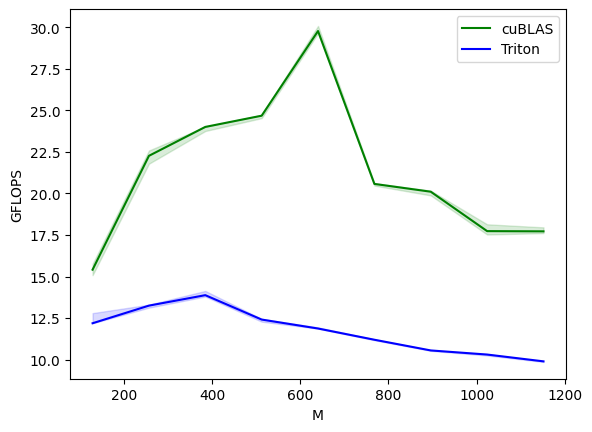

ternary-mul-3d-performance:
        M       N     cuBLAS     Triton
0   128.0   128.0  15.412983  12.190476
1   256.0   256.0  22.260869  13.250303
2   384.0   384.0  23.999999  13.879518
3   512.0   512.0  24.674699  12.412121
4   640.0   640.0  29.767443  11.873841
5   768.0   768.0  20.571428  11.198056
6   896.0   896.0  20.102565  10.554481
7  1024.0  1024.0  17.731602  10.307644
8  1152.0  1152.0  17.718344   9.897853


In [80]:
ref_lib = "cuBLAS"
K = 8

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 10)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GFLOPS",  # Label name for the y-axis
        plot_name="ternary-mul-3d-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
]

@triton.testing.perf_report(configs)
def benchmark(M, N, provider):
    print(f"Trial when K = {K}, M = {M}, N = {N}, for {provider}")
    x = torch.rand((K, M), device="cuda")
    w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (K, M, N))]
    scale = torch.rand(1, dtype=torch.float32).item()

    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_3d(x, w, scale), quantiles=quantiles)
    gflops = lambda ms: 2 * K * M * N * 1e-9 / (ms * 1e-3)
    return gflops(ms), gflops(max_ms), gflops(min_ms)


benchmark.run(show_plots=True, print_data=True)

## Generalized Ternary Multiplication Kernel (DOES NOT WORK FOR 4D AND ABOVE)

The autotune config should be similar to the 2D case.

In [ ]:
# def get_autotune_config():
#     if is_cuda():
#         return _get_autotune_config_2d()
#     else:
#         raise ValueError("Not on CUDA... can't use!")

The kernel's rough pseudocode algorithm is as follows.
```python
k = 0  # Output vector pointer

# Do in parallel
for i in range(0, num_elem_per_matrix, matrix_stride):
    # Do in parallel
    for j in range(0, num_elem_per_vector, vector_stride):
        matrix_elements = w_flat[i : i+matrix_stride].reshape(matrix_shape)
        vector_elements = x_flat[j : j+vector_stride]
        product = _2d_ternary_multiplication(vector_elements, matrix_elements, scale)
        output_flat[k : k+output_stride] = product
        k += output_stride

return output_flat.reshape(output_shape)
```

Note that `matrix_stride` and `vector_stride` may not be power-of-two values. Thus we will employ padding to ensure that achieve this, but using a mask to ensure that we don't get memory access errors.

In [ ]:
# # ruff: noqa: N803, PLR2044
# @triton.autotune(
#     configs=get_autotune_config(),
#     key=["M", "N"],
# )
# @triton.jit
# def ternary_mul_kernel(
#     # Pointers to arrays
#     x_ptr,
#     w_ptr,
#     z_ptr,
#     # Scaling factor
#     scale,
#     # # `W` matrix dimensions
#     M: tl.constexpr,
#     N: tl.constexpr,
#     # Strides
#     matrix_stride,
#     vector_stride,
#     stride_xm,
#     stride_wm,
#     stride_wn,
#     # Counts of matrices and vectors
#     num_stacked_matrices,
#     num_stacked_vectors,
#     # Meta-parameters
#     BLOCK_SIZE_M: tl.constexpr,
#     BLOCK_SIZE_N: tl.constexpr,
# ):
#     """
#     Kernel for computing the ternary multiplication
#         z = xW
#     `x` has shape `(..., M)`, `W` has shape `(..., M, N)`, and `z` has shape `(..., N)`.
#     """

#     # -----------------------------------------------------------
#     # Map `pid` to the correct `x` vector and `W` matrix blocks that we are computing
#     pid_0 = tl.program_id(axis=0)
#     pid_1 = tl.program_id(axis=1)
    
#     pid_vector = pid_1 % num_stacked_vectors
#     pid_matrix = pid_1 // num_stacked_vectors
    
#     # ----------------------------------------------------------
#     # Create pointers for the `x` vector and `W` matrix
#     offs_m = tl.arange(0, BLOCK_SIZE_M)
#     offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

#     offs_x = pid_vector * vector_stride + offs_m
#     offs_w = pid_matrix * matrix_stride + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)
    
#     x_ptrs = x_ptr + offs_x
#     w_ptrs = w_ptr + offs_w
    
#     # -----------------------------------------------------------
#     # Iterate to compute a block of the `z` vector.
#     # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
#     accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

#     for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
#         # Load the next block of `x` and `W`, generate a mask by checking along `M`.
#         # If it is out of bounds, set it to 0.
#         x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
#         w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

#         # Since `w` is ternary, we only really care about the sign of the element in the array, and so  we just need to
#         # perform two conditional checks
#         elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
#         accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

#         # Advance the ptrs to the next `M` block.
#         x_ptrs += BLOCK_SIZE_M * stride_xm
#         w_ptrs += BLOCK_SIZE_M * stride_wm

#     z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

#     # -----------------------------------------------------------
#     # Write back the block of the output vector `z` with masks
#     offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
#     z_ptrs = z_ptr + pid_1 * N + offs_z
#     z_mask = offs_z < N
#     tl.store(z_ptrs, z, mask=z_mask)

Create a convenience wrapper function that handles the checks and kernel calling.

In [ ]:
# # ruff: noqa: E731, S101, N806
# def ternary_mul(x, w, scale):
#     # Check constraints
#     assert x.ndim == w.ndim - 1, "Incompatible dimensionality"
#     assert x.shape[-1] == w.shape[-2], "Incompatible dimensions"
#     assert x.is_contiguous(), "x must be contiguous"

#     assert x.is_cuda and w.is_cuda

#     # Otherwise, we need to treat what we have as a stack of matrices.
#     # First we get the number of stacked matrices and vectors that we need to process
#     w_shape = w.shape
#     x_shape = x.shape

#     num_stacked_matrices = 1
#     num_stacked_vectors = 1
#     for i in range(w.ndim - 2):  # The last 2 indices are the matrices
#         num_stacked_matrices *= w_shape[i]
#         num_stacked_vectors *= x_shape[i]

#     # Identify the shape of the matrices and vectors that will actually be multiplied
#     matrix_shape = (w_shape[-2], w_shape[-1])
#     matrix_stride = w_shape[-2] * w_shape[-1]
#     vector_stride = x_shape[-1]
    
#     # Get dimensions
#     M, N = w_shape[-2], w_shape[-1]

#     # Determine output size and shape
#     if w.ndim == 2:
#         output_shape = [w_shape[-1]]
#         num_processes = 1  # No need for 2D launch grid
#     else:
#         output_shape = [*list(w_shape[:-2]), x_shape[-2], w_shape[-1]]
#         num_processes = num_stacked_matrices * x_shape[-2]
#     output = torch.zeros(output_shape, device=x.device)
    
#     # 2D launch kernel
#     grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]), num_processes)
    
#     # fmt: off
#     ternary_mul_kernel[grid](
#         x, w, output,
#         scale,
#         M, N,
#         matrix_stride, vector_stride, x.stride(-1), w.stride(-2), w.stride(-1),
#         num_stacked_matrices, num_stacked_vectors
#     )
#     # fmt: on

#     return output

Test the kernel.

In [ ]:
# X_SHAPE = (   3, 3, 1)  # x is the vector
# W_SHAPE = (3, 3, 1, 2)  # W is the quantized weights matrix

In [ ]:
# torch.manual_seed(8192)

In [ ]:
# x = torch.rand(X_SHAPE, device="cuda", dtype=torch.float32)
# w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SHAPE)]
# scale = torch.rand(1, dtype=torch.float32).item()

In [ ]:
# torch_output = torch.matmul(x, w) / scale
# print(torch_output)

In [ ]:
# triton_output = ternary_mul(x, w, scale)
# print(triton_output)

In [ ]:
# if torch.allclose(triton_output, torch_output, atol=1e-3):
#     print("✅ Triton and Torch match")
# else:
#     raise ValueError("❌ Triton and Torch differ")